# Comparing to N-body integrations

To facilitate comparison to N-body integrations, we have made a simple `NbodyRegressor` wrapper class, which simply initializes a `REBOUND` N-body integration. It uses the same parameters and interface as our `FeatureClassifier`.

Let's set up the same Simulation as in the Quickstart example:

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


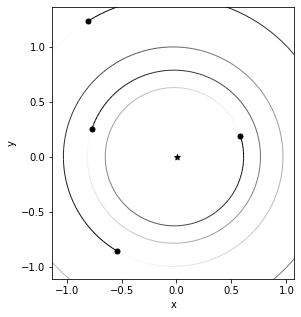

In [1]:
import rebound
%matplotlib inline

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1.e-4, P=3.14, e=0.03, l=0.3)
sim.add(m=1.e-4, P=4.396, e=0.03, l=2.8)
sim.add(m=1.e-4, P=6.28, e=0.03, l=4.2)
sim.add(m=1.e-4, P=10.99, e=0.03, l=2.1)
sim.move_to_com()
fig = rebound.OrbitPlot(sim)

The interface is the same:

We begin by making instances of the two classes:

In [2]:
from spock import FeatureClassifier
model = FeatureClassifier()

from spock import NbodyRegressor
nbody = NbodyRegressor()

The interface is the same:

In [3]:
%%time
model.predict_stable(sim)

CPU times: user 535 ms, sys: 3.1 ms, total: 538 ms
Wall time: 535 ms


0.0061098333

In [4]:
nbody.predict_stable(sim)

0

nbody returns a simple stable (1) or unstable (0), while the feature classifier returns an estimated probability of stability (unless it goes unstable within the first $10^4$ orbits used for the short N-body integration to generate features, in which case it returns exactly zero). We see the FeatureClassifier returns a sensible estimate.

The nbody cell above does not take long because the system only took about 29,000 orbits of the innermost planet to go unstable:

In [5]:
t_inst = nbody.predict_instability_time(sim) # instability time in time units used when setting up the Simulation
print('Went unstable after {0:.1f} orbits of the inner planet.'.format(t_inst/sim.particles[1].P))

Went unstable after 28919.2 orbits of the inner planet.


By default, these functions will integrate for a billion orbits of the planet with the shortest orbital period (the same threshold used by the stability classifier). So if you set up a stable system, these will take several hours to evaluate!

You can also set a different maximum integration time (in simulation time units). Let's integrate for 10,000 orbits of the innermost planet:

In [6]:
nbody.predict_stable(sim, tmax=1e4*sim.particles[1].P)

1

Note that the above prediction will not be a one-to-one comparison with our `FeatureClassifier` which has been trained on a dataset integrated for a billion orbits of the innermost planet. 

If `predict_instability_time` reaches tmax, it will just return tmax as the "instability time":

In [7]:
t_inst = nbody.predict_instability_time(sim, tmax=1e4*sim.particles[1].P)
print(t_inst)

31400.00000000001


Note that this can look like an arbitrary number! It's a good idea to check whether it's a real instability time, or whether you've just hit tmax:

In [8]:
print(t_inst/sim.particles[1].P)

10000.0


# Simulation Archives

Because the N-body integrations can take several hours of computation time, we provide an option to save `SimulationArchives`, binary snapshots which you can later examine or reload to run further. These make it easy to reproducibly share N-body integrations (see Rein & Tamayo 2017).

You specify the filename (and path), and the time between snapshots (in Simulation time units). The latter defaults to a value that will give you 1000 snapshots if the integration remains stable the entire time. This way archives don't take up too much space, but here we hardcode a short interval since the system has a short survival time. 1000 snapshots corresponds to a few MB.

__Note that this function will overwrite if the same filename already exists.__

In [9]:
nbody.predict_instability_time(sim, archive_filename='test.bin', archive_interval=1e2)

90806.15665630097

We can now reopen and inspect for example the eccentricities of the second planet at each snapshot. 

Text(0, 0.5, 'Planet 2 Eccentricity')

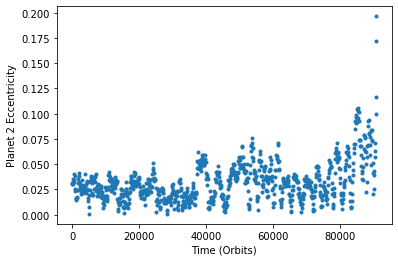

In [10]:
import rebound
import matplotlib.pyplot as plt
%matplotlib inline

sa = rebound.SimulationArchive('test.bin')
times, e = [], []
for sim in sa:
    times.append(sim.t)
    e.append(sim.particles[2].e)
    
fig, ax =plt.subplots()
ax.plot(times, e, '.')
ax.set_xlabel('Time (Orbits)')
ax.set_ylabel('Planet 2 Eccentricity')

In the case of a collision, the archive also contains a final snapshot of the state at the time the collision was detected:

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcbf0c4c7d0>)

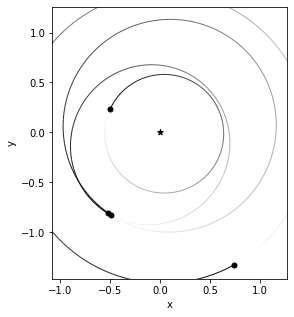

In [11]:
rebound.OrbitPlot(sa[-1])

For more information on the SimulationArchive, see https://github.com/hannorein/rebound/blob/master/ipython_examples/SimulationArchive.ipynb and https://github.com/hannorein/rebound/blob/master/ipython_examples/SimulationArchiveRestart.ipynb for more details.

# Going Further

The `NbodyRegressor` wrapper provides minimal functionality for easy comparisons to N-body integrations. If you want to go further you can always set integration parameters and run it yourself. 

For reference, all classes in SPOCK initialize simulation parameters with the `init_sim_parameters` function in spock/spock/simsetup.py. It:

* sets the timestep to 5% of the shortest pericenter passage time among all planets (Wisdom 2015)
* sets the integrator to WHFast (switches to IAS15 if e > 0.99, avoiding prohibitively short WHFast timestep)
* initializes MEGNO and sets collision detection
* overwrites any existing particle radii with their individual Hill radii for collision detection
* moves to the center-of-mass frame
* sets ri_whfast.safe_mode to 1

In particular, if you don't want to calculate the MEGNO and understand the consequences (https://github.com/hannorein/rebound/blob/master/ipython_examples/AdvWHFast.ipynb), you can skip `sim.init_megno()` and set `ri_whfast.safe_mode` to 0 to gain > a factor of two in computation time.

However, planetary systems are generally chaotic. If you do this (or change other parameters), you will not get the same chaotic realization of the trajectory as `FeatureClassifier` and `NbodyRegressor`. In principle this is not a problem, since each chaotic realization is equally valid, but it is something to keep in mind when wondering why one Nbody integration collides at 1e4 orbits and another at 5e4 (see Hussain & Tamayo 2019 for how instability times are typically distributed). 

We have tested in particular that the `FeatureClassifier` trained with a slightly different timestep than our N-body integrations (thus sampling different chaotic realizations) has the same performance as one trained using the exact same timestep and trajectories.